In [1]:
#include the utility functions from noise.jl and plting utility
include("noise.jl")
using Plots

This implementation of perlin noise is based on [these](https://www.cs.umd.edu/class/spring2018/cmsc425/index.shtml) course notes by Dave Mount and Roger Eastman at the University of Maryland. The lecture notes are in turn based on Ken Perlin's works [here](https://web.archive.org/web/20180418002912/http://mrl.nyu.edu/~perlin/paper445.pdf).

To start, I define a $x_n$ by $y_n$ grid and overlay a lattice made of squares with side length $\ell$. The goal is to calculate a noise value at the center of each grid square. This visualizes the noise calculation at some test point $\vec{r}$.

In [2]:
#grid size
xn::Int64 = 20
yn::Int64 = 20

#square lattice size
l::Int64 = 10

#round of xn and yn to be l divisible
xn = round(Int64,xn/l)*l
yn = round(Int64,yn/l)*l

#seed to use later
g_seed = 12147182

12147182

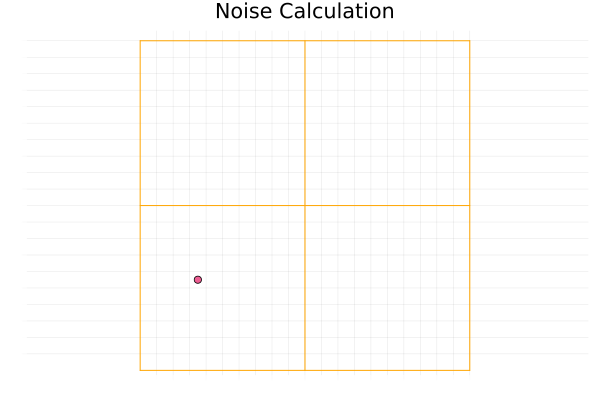

In [3]:
p = plot(aspect_ratio=:equal,legend=false,xticks=(1:xn,[]),yticks=(1:yn,[]),title="Noise Calculation",
    bordercolor=:white,x_foreground_color_axis=:white, y_foreground_color_axis=:white)
bar(X,Y) = plot!(p,X,Y,color=:orange)
for i∈0:(xn/l)
    bar([i*l,i*l],[0,yn])
end

for i∈0:(yn/l)
    bar([0,xn],[i*l,i*l])
end

tp_x,tp_y = [0.5*7 ],[0.5*11 ]
scatter!(p,tp_x,tp_y)

p

I then pseudo-randomly assign a unit vector from a pool of 8 precomputed vectors to the edge point of each lattice grid.

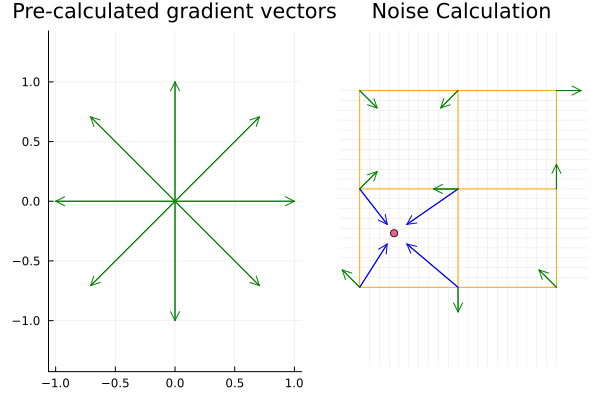

In [4]:
gradient_color = :green

p1 = plot(legend=false,title="Pre-calculated gradient vectors",aspect_ratio=:equal)
gam = size(noise.G)[1]
orig = [0 for _ in 1:gam]
quiver!(p1,orig,orig,quiver=([noise.G[i][1] for i in 1:gam],[noise.G[i][2] for i in 1:gam]),color=gradient_color)

#identify the corners
x_ind = floor(tp_x[1]/l)
y_ind = floor(tp_y[1]/l)
X_corners = [x_ind*l,x_ind*l,(x_ind+1)*l,(x_ind+1)*l] 
Y_corners = [y_ind*l,(y_ind+1)*l,y_ind*l,(y_ind+1)*l]
# scatter!(p,X_corners,Y_corners)
U = (repeat(tp_x,4) .- X_corners) .* 0.8
V = (repeat(tp_y,4) .- Y_corners) .* 0.8
quiver!(p,X_corners,Y_corners, quiver=( U,V) , color=:blue)

#generate gradient and place them at corners
gradients = noise.select_gradient(xn,yn,l,g_seed)
for i=1:Int(xn/l)+1 ,j=1:Int(yn/l)+1
    x = (i - 1) * l
    y = (j - 1) * l
    u,v = gradients[i,j,:] .* l/4
    quiver!(p,[x],[y], quiver=([u],[v]),color=gradient_color,alpha=1)
end

plot(p1,p,layout=(1,2))

Then consider how "aligned" this position is with each gradient vector. This is calculated by considering the product of a corner's gradient vector with with the vector from that corner to the test point: $ \vec{g}_i \cdot (\vec{r} - \vec{l}_i)$, where vectors $\vec{r}$, $\vec{l}_i$, $\vec{g}_i$ are the test point, corner location and gradient vector respectively.

These values need to be softened since they don't take into acount (and are actualy inversly proportional to this) the fact that values should be greater when the test point is near a corner. This is done by using a fading function, $\psi:[0,1]x[0,1]\rightarrow [0,1]$ with the property that $\psi(0,0)=0$ and $\psi(1,1)=1$.

In particular I use $\psi(x,y)=(6x^5 - 15x^4 + 10x^3)(6y^5 - 15y^4 + 10y^3)$

This function has zero first and second derivatives at $(0,0)$ and $(1,1)$, this removes artifcats and is an improvemtn from the original function proposed by Perlin. This function is applied diffrently to each corner term. Firstly the coorinate of the test point is scaled and so that it's on a $[0,1]x[0,1]$ square defined by the latice square it lies on. Then based on the corner a coordinate might be transformed $s\rightarrow 1-s$ so that the $(1,1)$ point corresponds with a particular corner.

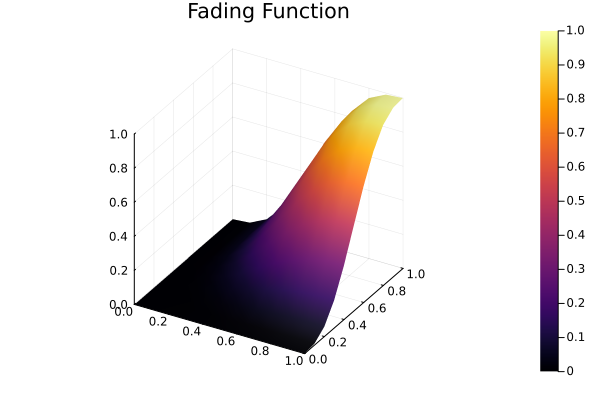

In [5]:
#plot the fading function
xrang = 0:0.1:1
yrang = 0:0.1:1
plot3d(xrang,yrang,noise.ψ,st=:surface,title="Fading Function")

Once this is applied each corner it gets multiplied into each term to give a sum: 

$$F(\vec{r}) = \psi'_1(\vec{r}) \bigg{(} \vec{g}_1 \cdot (\vec{r} - \vec{l}_1) \bigg{)} + \psi'_2(\vec{r}) \bigg{(} \vec{g}_2 \cdot (\vec{r} - \vec{l}_2) \bigg{)} + \psi'_3(\vec{r}) \bigg{(} \vec{g}_3 \cdot (\vec{r} - \vec{l}_3) \bigg{)} + \psi'_4(\vec{r}) \bigg{(} \vec{g}_4 \cdot (\vec{r} - \vec{l}_4) \bigg{)}$$

This is then normalized so that $F:\mathbb{R}^2\rightarrow [0,1]$.

This can be further improved by adding scaled copies of the noise evaluated at diffrent points,

$$\text{noise}(x,y) = \Sigma_{i\leq k} p^i \cdot F(x+2^i,y+2^i) $$

where $0\leq p \leq 1$ and some integer $k$. This adds in some nice fractal like properties to enhance the noise.

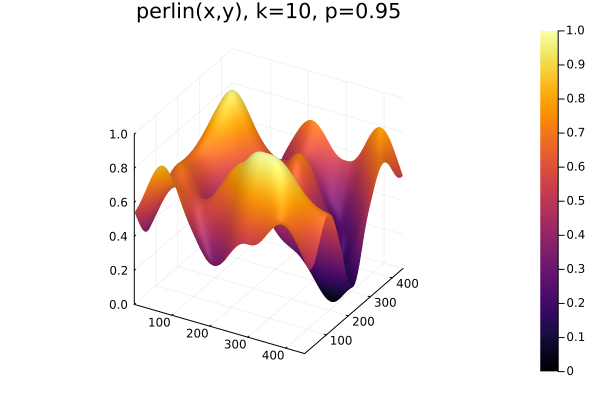

In [6]:
prl = noise.perlin_mesh(450,450,150,0.95,10,seed=g_seed)

#map the noise functions onto a graph
fs(x,y) = prl[x,y]
mesh = plot3d(1:450,1:450,fs,st=:surface,title="perlin(x,y), k=10, p=0.95")
mesh

In [7]:
savefig(mesh,"figs/PerlinNoiseDemo.png")